CODE BLOCK: 1

In [1]:
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from tabnanny import verbose

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
class TrainingReportGenerator:
    def __init__(self, reports_dir="reports"):
        self.reports_dir = reports_dir
        self._ensure_reports_directory()
        self.report_data = {
            'experiment_info': {},
            'model_info': {},
            'training_history': [],
            'test_results': {},
            'plots': [],
            'metadata': {}
        }
    
    def _ensure_reports_directory(self):
        """Create reports directory if it doesn't exist"""
        if not os.path.exists(self.reports_dir):
            os.makedirs(self.reports_dir)
            print(f"Created reports directory: {self.reports_dir}")
    
    def log_experiment_info(self, model_name, dataset, batch_size, epochs, optimizer, scheduler=None):
        """Log basic experiment information"""
        self.report_data['experiment_info'] = {
            'model_name': model_name,
            'dataset': dataset,
            'batch_size': batch_size,
            'epochs': epochs,
            'optimizer': str(optimizer),
            'scheduler': str(scheduler) if scheduler else None,
            'timestamp': datetime.now().isoformat(),
            'device': str(device) if 'device' in globals() else 'unknown'
        }
    
    def log_model_info(self, model):
        """Log model architecture information"""
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        self.report_data['model_info'] = {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_architecture': str(model)
        }
    
    def log_epoch_results(self, epoch, train_loss, train_acc, test_loss, test_acc, lr=None):
        """Log results for each epoch - handles both single values and lists"""
        # Helper function to extract single value from list or return the value
        def extract_value(value):
            if isinstance(value, list):
                return value[-1] if value else 0
            return value
        
        epoch_data = {
            'epoch': epoch,
            'train_loss': extract_value(train_loss),
            'train_accuracy': extract_value(train_acc),
            'test_loss': extract_value(test_loss),
            'test_accuracy': extract_value(test_acc),
            'learning_rate': lr
        }
        self.report_data['training_history'].append(epoch_data)
    
    def log_final_test_results(self, final_test_loss, final_test_acc, incorrect_predictions=None):
        """Log final test results - handles both single values and lists"""
        # Handle case where final_test_acc is a list (take the last value)
        if isinstance(final_test_acc, list):
            final_test_acc_value = final_test_acc[-1] if final_test_acc else 0
        else:
            final_test_acc_value = final_test_acc
        
        # Handle case where final_test_loss is a list (take the last value)
        if isinstance(final_test_loss, list):
            final_test_loss_value = final_test_loss[-1] if final_test_loss else 0
        else:
            final_test_loss_value = final_test_loss
        
        self.report_data['test_results'] = {
            'final_test_loss': float(final_test_loss_value),
            'final_test_accuracy': float(final_test_acc_value),
            'incorrect_predictions_count': len(incorrect_predictions) if incorrect_predictions else 0
        }
    
    def add_plot(self, plot_type, title, description=""):
        """Add a plot to the report"""
        # Capture current matplotlib figure
        fig = plt.gcf()
        buffer = BytesIO()
        fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
        buffer.seek(0)
        plot_data = base64.b64encode(buffer.getvalue()).decode()
        plt.close(fig)
        
        self.report_data['plots'].append({
            'type': plot_type,
            'title': title,
            'description': description,
            'data': plot_data
        })
    
    def generate_html_report(self, filename=None, custom_name=None):
        """Generate HTML report in the reports directory"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = self.report_data['experiment_info'].get('model_name', 'model')
            dataset = self.report_data['experiment_info'].get('dataset', 'dataset')
            
            if custom_name:
                filename = f"{custom_name}_{timestamp}.html"
            else:
                filename = f"{model_name}_{dataset}_{timestamp}.html"
        
        # Ensure filename has .html extension
        if not filename.endswith('.html'):
            filename += '.html'
        
        # Create full path in reports directory
        filepath = os.path.join(self.reports_dir, filename)
        
        html_content = self._create_html_template()
        
        with open(filepath, 'w') as f:
            f.write(html_content)
        
        print(f"HTML report generated: {filepath}")
        return filepath
    
    def _create_html_template(self):
        """Create HTML template with embedded data"""
        exp_info = self.report_data['experiment_info']
        model_info = self.report_data['model_info']
        training_history = self.report_data['training_history']
        test_results = self.report_data['test_results']
        plots = self.report_data['plots']
        
        # Safe formatting with fallbacks
        final_acc = test_results.get('final_test_accuracy', 0)
        final_loss = test_results.get('final_test_loss', 0)
        total_epochs = len(training_history)
        total_params = model_info.get('total_parameters', 0)
        
        html = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Training Report - {exp_info.get('model_name', 'Unknown Model')}</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
        .container {{ max-width: 1200px; margin: 0 auto; background-color: white; padding: 30px; border-radius: 10px; box-shadow: 0 0 20px rgba(0,0,0,0.1); }}
        h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 30px; }}
        .info-grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 20px; margin: 20px 0; }}
        .info-card {{ background-color: #ecf0f1; padding: 20px; border-radius: 8px; border-left: 4px solid #3498db; }}
        .metric {{ display: flex; justify-content: space-between; margin: 10px 0; padding: 8px; background-color: #fff; border-radius: 4px; }}
        .metric-value {{ font-weight: bold; color: #27ae60; }}
        table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
        th, td {{ padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
        .plot-container {{ text-align: center; margin: 30px 0; }}
        .plot-container img {{ max-width: 100%; height: auto; border: 1px solid #ddd; border-radius: 8px; }}
        .summary-stats {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 15px; margin: 20px 0; }}
        .stat-card {{ background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px; border-radius: 10px; text-align: center; }}
        .stat-value {{ font-size: 2em; font-weight: bold; margin: 10px 0; }}
        .timestamp {{ color: #7f8c8d; font-size: 0.9em; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>🧠 Training Report</h1>
        <p class="timestamp">Generated on: {exp_info.get('timestamp', 'Unknown')}</p>
        
        <h2> Experiment Summary</h2>
        <div class="summary-stats">
            <div class="stat-card">
                <div>Final Accuracy</div>
                <div class="stat-value">{final_acc:.2f}%</div>
            </div>
            <div class="stat-card">
                <div>Final Loss</div>
                <div class="stat-value">{final_loss:.4f}</div>
            </div>
            <div class="stat-card">
                <div>Total Epochs</div>
                <div class="stat-value">{total_epochs}</div>
            </div>
            <div class="stat-card">
                <div>Model Parameters</div>
                <div class="stat-value">{total_params:,}</div>
            </div>
        </div>
        
        <h2>🔧 Experiment Configuration</h2>
        <div class="info-grid">
            <div class="info-card">
                <h3>Model & Dataset</h3>
                <div class="metric"><span>Model:</span><span class="metric-value">{exp_info.get('model_name', 'Unknown')}</span></div>
                <div class="metric"><span>Dataset:</span><span class="metric-value">{exp_info.get('dataset', 'Unknown')}</span></div>
                <div class="metric"><span>Device:</span><span class="metric-value">{exp_info.get('device', 'Unknown')}</span></div>
            </div>
            <div class="info-card">
                <h3>Training Parameters</h3>
                <div class="metric"><span>Batch Size:</span><span class="metric-value">{exp_info.get('batch_size', 'Unknown')}</span></div>
                <div class="metric"><span>Epochs:</span><span class="metric-value">{exp_info.get('epochs', 'Unknown')}</span></div>
                <div class="metric"><span>Trainable Params:</span><span class="metric-value">{model_info.get('trainable_parameters', 0):,}</span></div>
            </div>
        </div>
        
        <h2>📈 Training History</h2>
        <table>
            <thead>
                <tr>
                    <th>Epoch</th>
                    <th>Train Loss</th>
                    <th>Train Acc (%)</th>
                    <th>Test Loss</th>
                    <th>Test Acc (%)</th>
                    <th>Learning Rate</th>
                </tr>
            </thead>
            <tbody>
"""
        
        # Add training history rows with safe formatting
        for epoch_data in training_history:
            train_loss = epoch_data.get('train_loss', 0)
            train_acc = epoch_data.get('train_accuracy', 0)
            test_loss = epoch_data.get('test_loss', 0)
            test_acc = epoch_data.get('test_accuracy', 0)
            lr = epoch_data.get('learning_rate', 'N/A')
            
            # Safe formatting function
            def safe_format(value, format_str):
                try:
                    if isinstance(value, (int, float)):
                        return format_str.format(value)
                    else:
                        return str(value)
                except:
                    return str(value)
            
            html += f"""
                <tr>
                    <td>{epoch_data.get('epoch', 'N/A')}</td>
                    <td>{safe_format(train_loss, '{:.4f}')}</td>
                    <td>{safe_format(train_acc, '{:.2f}')}</td>
                    <td>{safe_format(test_loss, '{:.4f}')}</td>
                    <td>{safe_format(test_acc, '{:.2f}')}</td>
                    <td>{lr}</td>
                </tr>
"""
        
        html += """
            </tbody>
        </table>
        
        <h2> Training Plots</h2>
"""
        
        # Add plots
        for plot in plots:
            html += f"""
        <div class="plot-container">
            <h3>{plot.get('title', 'Plot')}</h3>
            <p>{plot.get('description', '')}</p>
            <img src="data:image/png;base64,{plot.get('data', '')}" alt="{plot.get('title', 'Plot')}">
        </div>
"""
        
        html += """
    </div>
</body>
</html>
"""
        return html


In [3]:
report_gen = TrainingReportGenerator(reports_dir="reports")

CODE BLOCK: 2

In [4]:
# Check for MPS (Metal Performance Shaders) availability on Apple Silicon
mps_available = torch.backends.mps.is_available()
print(f"MPS Available: {mps_available}")

# Check if MPS is built
mps_built = torch.backends.mps.is_built()
print(f"MPS Built: {mps_built}")

# Set device based on availability
if mps_available and mps_built:
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Selected device: {device}")

# Test MPS with a simple tensor operation
if device.type == "mps":
    try:
        # Create a simple tensor on MPS
        test_tensor = torch.randn(3, 3, device=device)
        result = test_tensor @ test_tensor.T
        print("✅ MPS test successful!")
        print(f"Test tensor shape: {test_tensor.shape}")
        print(f"Result tensor shape: {result.shape}")
    except Exception as e:
        print(f"❌ MPS test failed: {e}")
        print("Falling back to CPU")
        device = torch.device("cpu")


MPS Available: True
MPS Built: True
Using MPS (Apple Silicon GPU)
Selected device: mps
✅ MPS test successful!
Test tensor shape: torch.Size([3, 3])
Result tensor shape: torch.Size([3, 3])


CODE BLOCK: 3

In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [7]:
print(f"Train Data shape: {train_data.targets.shape}, Test Data shape:  {test_data.targets.shape}")

Train Data shape: torch.Size([60000]), Test Data shape:  torch.Size([10000])


In [ ]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [9]:
print(f"Train Loader Data Shape: {train_loader.dataset.targets.shape}, Test Loader Data Shape:  {test_loader.dataset.targets.shape}")

Train Loader Data Shape: torch.Size([60000]), Test Loader Data Shape:  torch.Size([10000])


CODE BLOCK: 6

/Users/pankajkumar/Documents/git/TSAI/ERA4/S4/mnist-training-epo1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


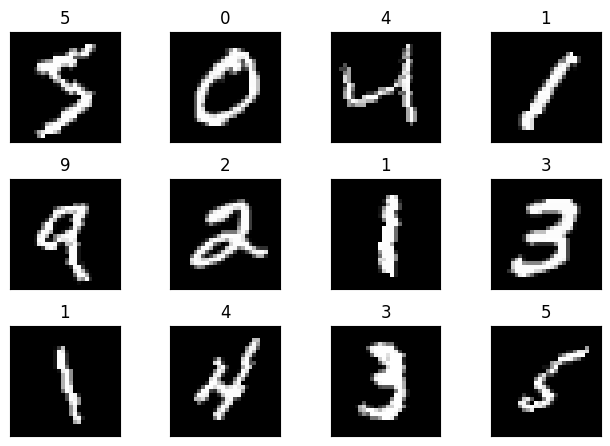

In [10]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [11]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256*4*4, 50) # 16000
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [13]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))
  report_gen.log_model_info(model)

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [14]:
learning_rate = 0.001
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True) # torch error saying verbose is not supported
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')
num_epochs = 1

report_gen.log_experiment_info(
    model_name="CNN Model",
    dataset="MNIST",
    batch_size=batch_size,
    epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler
    )

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_criterion)
  test(model, device, train_loader, test_criterion)
  report_gen.log_epoch_results(epoch, train_losses, train_acc, test_losses, test_acc, learning_rate)
  scheduler.step()

Epoch 1


Train: Loss=0.7860 Batch_id=234 Accuracy=43.60: 100%|██████████| 235/235 [00:03<00:00, 62.47it/s] 


Test set: Average loss: 0.7006, Accuracy: 46045/60000 (76.74%)



CODE BLOCK: 11

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

report_gen.add_plot("training_curves", "Training and Test Curves", "Loss and accuracy over epochs")

In [16]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Linear: 1-5                            204,850
├─Linear: 1-6                            510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Linear: 1-5                            204,850
├─Linear: 1-6                            510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0

In [17]:
# Generate final report
report_gen.log_final_test_results(test_losses, test_acc, test_incorrect_pred)
report_gen.generate_html_report()

HTML report generated: reports/CNN Model_MNIST_20250919_133221.html


'reports/CNN Model_MNIST_20250919_133221.html'